In [15]:

# @markdown ## Тема: Сравнительный анализ производительности методов загрузки данных в PostgreSQL

# @markdown ---

# @markdown ## Цель:
# @markdown Определить наиболее эффективный метод загрузки данных (малых и больших объемов) из CSV-файлов в СУБД PostgreSQL, сравнивая время выполнения для методов: `pandas.to_sql()`, `psycopg2.copy_expert()` (с файлом и с `io.StringIO`), и пакетная вставка (`psycopg2.extras.execute_values`).

# @markdown ---

# @markdown ## Задачи:
# @markdown 1.  **Подключиться** к предоставленной базе данных PostgreSQL.
# @markdown 2.  **Проанализировать структуру** исходных CSV-файлов (`upload_test_data.csv`, `upload_test_data_big.csv`).
# @markdown 3.  **Создать эскизы ER-диаграмм** для таблиц, соответствующих структуре CSV-файлов.
# @markdown 4.  **Реализовать** четыре различных метода загрузки данных в PostgreSQL.
# @markdown 5.  **Измерить время**, затраченное каждым методом на загрузку данных из малого файла (`upload_test_data.csv`).
# @markdown 6.  **Измерить время**, затраченное каждым методом на загрузку данных из большого файла (`upload_test_data_big.csv`).
# @markdown 7.  **Визуализировать** результаты сравнения времени загрузки с помощью гистограммы (`matplotlib`).
# @markdown 8.  **Сделать выводы** об эффективности каждого метода для разных объемов данных.

In [16]:
!pip install psycopg2-binary pandas sqlalchemy matplotlib numpy

In [17]:
import psycopg2
from psycopg2 import Error
from psycopg2 import extras # For execute_values
import pandas as pd
from sqlalchemy import create_engine
import io # For StringIO
import time
import matplotlib.pyplot as plt
import numpy as np
import os # To check file existence


In [18]:
small_csv_path = r'C:\Users\arssi\Downloads\upload_test_data.csv'

In [19]:
big_csv_path = r'C:\Users\arssi\Downloads\upload_test_data_big.csv'

In [20]:
!ls

"ls" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [21]:

# @markdown Установка и импорт необходимых библиотек.


print("Libraries installed and imported successfully.")

# Database connection details (replace with your actual credentials if different)
DB_USER = "postgres"
DB_PASSWORD = "1"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "big_data"

# CSV File Paths (Ensure these files are uploaded to your Colab environment)
small_csv_path = r'C:\Users\arssi\Downloads\upload_test_data.csv'
big_csv_path = r'C:\Users\arssi\Downloads\upload_test_data_big.csv'

# Table name in PostgreSQL
table_name = 'sales_data'

Libraries installed and imported successfully.


In [22]:
# @title # 3. Database Connection Test
# @markdown Проверка соединения с базой данных PostgreSQL.

connection = None
cursor = None
engine = None # For pandas.to_sql

try:
    # Establish connection using psycopg2
    print("Connecting to PostgreSQL database using psycopg2...")
    connection = psycopg2.connect(user=DB_USER,
                                  password=DB_PASSWORD,
                                  host=DB_HOST,
                                  port=DB_PORT,
                                  database=DB_NAME)
    connection.autocommit = False # Important for COPY and batch inserts within transactions
    cursor = connection.cursor()

    print("PostgreSQL server information:")
    print(connection.get_dsn_parameters(), "\n")
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print(f"Successfully connected to: {record[0]}\n")

    # Create SQLAlchemy engine for pandas
    print("Creating SQLAlchemy engine...")
    engine_url = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
    engine = create_engine(engine_url)
    print("SQLAlchemy engine created successfully.")


except (Exception, Error) as error:
    print(f"Error while connecting to PostgreSQL: {error}")
    # Ensure resources are closed even if connection fails partially
    if cursor:
        cursor.close()
    if connection:
        connection.close()
    if engine:
        engine.dispose() # Close SQLAlchemy engine pool
    connection, cursor, engine = None, None, None # Reset variables

# We keep the connection open for the rest of the script.
# It will be closed in the final step.

Connecting to PostgreSQL database using psycopg2...
PostgreSQL server information:
{'user': 'postgres', 'channel_binding': 'prefer', 'dbname': 'big_data', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslcertmode': 'allow', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'disable', 'krbsrvname': 'postgres', 'gssdelegation': '0', 'target_session_attrs': 'any', 'load_balance_hosts': 'disable'} 

Successfully connected to: PostgreSQL 17.4 on x86_64-windows, compiled by msvc-19.42.34436, 64-bit

Creating SQLAlchemy engine...
SQLAlchemy engine created successfully.


In [23]:
# @title # 4. Data Source Analysis and ER Diagram Sketch
# @markdown Анализ структуры CSV файлов и создание эскиза ER-диаграммы.

# @markdown ---
# @markdown ## 4.1. Анализ структуры данных

# @markdown Загрузим небольшой фрагмент данных из каждого файла, чтобы увидеть структуру.

if connection: # Proceed only if connection is established
    try:
        print(f"--- Analyzing {small_csv_path} ---")
        if os.path.exists(small_csv_path):
            df_small_sample = pd.read_csv(small_csv_path, nrows=5)
            print("First 5 rows:")
            print(df_small_sample)
            print("\nData Types (inferred by Pandas):")
            print(df_small_sample.info())
        else:
            print(f"ERROR: File not found: {small_csv_path}. Please upload it.")

        print(f"\n--- Analyzing {big_csv_path} ---")
        if os.path.exists(big_csv_path):
            df_big_sample = pd.read_csv(big_csv_path, nrows=5)
            print("First 5 rows:")
            print(df_big_sample)
            print("\nData Types (inferred by Pandas):")
            print(df_big_sample.info())
        else:
             print(f"ERROR: File not found: {big_csv_path}. Please upload it.")

    except Exception as e:
        print(f"An error occurred during file analysis: {e}")
else:
    print("Database connection not established. Skipping data analysis.")


# @markdown ---
# @markdown ## 4.2. Эскиз ER-диаграммы (для обоих источников)

# @markdown Поскольку оба CSV файла содержат одинаковые колонки (`id`, `quantity`, `cost`, `total_revenue`), структура базы данных будет идентичной для обоих источников. Она будет состоять из одной таблицы.

# @markdown **Таблица: `sales_data`**
# @markdown *   `id` : INTEGER (Primary Key) - Уникальный идентификатор записи.
# @markdown *   `quantity` : INTEGER - Количество проданных единиц товара.
# @markdown *   `cost` : NUMERIC(10, 2) - Стоимость одной единицы товара. (Используем NUMERIC для точности).
# @markdown *   `total_revenue` : NUMERIC(12, 2) - Общая выручка (quantity * cost). (Используем NUMERIC для точности).

# @markdown **Визуальное представление (текстовое):**
# @markdown ```
# @markdown +-----------------+
# @markdown |   sales_data    |
# @markdown +-----------------+
# @markdown | PK id INTEGER     |
# @markdown |    quantity INTEGER |
# @markdown |    cost NUMERIC(10,2) |
# @markdown |    total_revenue NUMERIC(12,2) |
# @markdown +-----------------+
# @markdown ```
# @markdown *Примечание: Связи отсутствуют, так как у нас только одна таблица в данной задаче.*

--- Analyzing C:\Users\arssi\Downloads\upload_test_data.csv ---
First 5 rows:
   id  quantity  cost  total_revenue
0   1        33  0.50          16.50
1   2        16  6.92         110.72
2   3        17  7.77         132.09
3   4        17  7.73         131.41
4   5         9  3.07          27.63

Data Types (inferred by Pandas):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             5 non-null      int64  
 1   quantity       5 non-null      int64  
 2   cost           5 non-null      float64
 3   total_revenue  5 non-null      float64
dtypes: float64(2), int64(2)
memory usage: 292.0 bytes
None

--- Analyzing C:\Users\arssi\Downloads\upload_test_data_big.csv ---
First 5 rows:
   id  quantity  cost  total_revenue
0   1        33  0.50          16.50
1   2        16  6.92         110.72
2   3        17  7.77         132.09
3   4      

In [24]:
# @title # 5. Database Table Preparation
# @markdown Создание таблицы в PostgreSQL перед загрузкой данных.

if connection and cursor:
    try:
        # Drop the table if it exists (for repeatable testing)
        print(f"Dropping table '{table_name}' if it exists...")
        cursor.execute(f"DROP TABLE IF EXISTS {table_name};")
        connection.commit() # Commit the drop
        print(f"Table '{table_name}' dropped successfully or did not exist.")

        # Create the table with the defined schema
        create_table_query = f"""
        CREATE TABLE {table_name} (
            id INTEGER PRIMARY KEY,
            quantity INTEGER,
            cost NUMERIC(10, 2),
            total_revenue NUMERIC(12, 2)
        );
        """
        print(f"Creating table '{table_name}'...")
        cursor.execute(create_table_query)
        connection.commit() # Commit the creation
        print(f"Table '{table_name}' created successfully.")

    except (Exception, Error) as error:
        print(f"Error during table preparation: {error}")
        connection.rollback() # Rollback changes if error occurs

else:
    print("Database connection not established. Skipping table preparation.")

# Helper function to reset table data between tests
def reset_table(conn, cur, tbl_name):
    """Truncates the specified table."""
    try:
        cur.execute(f"TRUNCATE TABLE {tbl_name};")
        conn.commit()
        # print(f"Table '{tbl_name}' truncated.")
    except (Exception, Error) as error:
        print(f"Error truncating table {tbl_name}: {error}")
        conn.rollback()

Dropping table 'sales_data' if it exists...
Table 'sales_data' dropped successfully or did not exist.
Creating table 'sales_data'...
Table 'sales_data' created successfully.


In [25]:
# @title # 6. Data Loading Methods Implementation and Timing
# @markdown Реализация и измерение времени для каждого метода загрузки.

# Dictionary to store timing results
timing_results = {
    'small_file': {},
    'big_file': {}
}

# Check if files exist before proceeding
if not os.path.exists(small_csv_path):
    print(f"ERROR: Small CSV file not found: {small_csv_path}. Upload it and restart.")
elif not os.path.exists(big_csv_path):
    print(f"ERROR: Big CSV file not found: {big_csv_path}. Upload it and restart.")
elif not connection or not cursor or not engine:
    print("ERROR: Database connection not ready. Cannot proceed.")
else:
    # --- Method 1: pandas.to_sql() ---
    def load_with_pandas_to_sql(eng, df, tbl_name, chunk_size=1000):
        """Loads data using pandas.to_sql() and returns time taken."""
        start_time = time.perf_counter()
        try:
            # Using method='multi' might be faster for some DBs/data
            # Chunksize helps manage memory for large files
            df.to_sql(tbl_name, eng, if_exists='append', index=False, method='multi', chunksize=chunk_size)
        except Exception as e:
             print(f"Error in pandas.to_sql: {e}")
             # Note: No explicit transaction management here, relies on SQLAlchemy/DBAPI defaults or engine settings.
             # For critical data, wrap in a try/except with explicit rollback if needed.
             raise # Re-raise the exception to signal failure
        end_time = time.perf_counter()
        return end_time - start_time

    # --- Method 2: psycopg2.copy_expert() with CSV file ---
    def load_with_copy_expert_file(conn, cur, tbl_name, file_path):
        """Loads data using psycopg2.copy_expert() directly from file and returns time taken."""
        start_time = time.perf_counter()
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                # Skip header row using COPY options
                sql_copy = f"""
                COPY {tbl_name} FROM STDIN WITH (FORMAT CSV, HEADER TRUE, DELIMITER ',')
                """
                cur.copy_expert(sql=sql_copy, file=f)
            conn.commit() # Commit transaction after successful COPY
        except (Exception, Error) as error:
            print(f"Error in copy_expert (file): {error}")
            conn.rollback() # Rollback on error
            raise
        end_time = time.perf_counter()
        return end_time - start_time

    # --- Method 3: psycopg2.copy_expert() with io.StringIO ---
    def load_with_copy_expert_stringio(conn, cur, df, tbl_name):
        """Loads data using psycopg2.copy_expert() from an in-memory StringIO buffer and returns time taken."""
        start_time = time.perf_counter()
        buffer = io.StringIO()
        # Write dataframe to buffer as CSV, including header
        df.to_csv(buffer, index=False, header=True, sep=',')
        buffer.seek(0) # Rewind buffer to the beginning
        try:
            sql_copy = f"""
            COPY {tbl_name} FROM STDIN WITH (FORMAT CSV, HEADER TRUE, DELIMITER ',')
            """
            cur.copy_expert(sql=sql_copy, file=buffer)
            conn.commit() # Commit transaction after successful COPY
        except (Exception, Error) as error:
            print(f"Error in copy_expert (StringIO): {error}")
            conn.rollback() # Rollback on error
            raise
        finally:
            buffer.close() # Ensure buffer is closed
        end_time = time.perf_counter()
        return end_time - start_time


    # --- Timing Execution ---
    print("\n--- Starting Data Loading Tests ---")

    # Load DataFrames (only once)
    print("Loading CSV files into Pandas DataFrames...")
    try:
        df_small = pd.read_csv(small_csv_path)
        # The big file might be too large to load fully into Colab memory.
        # If memory errors occur, consider processing it in chunks for methods
        # that support it (like pandas.to_sql with chunksize, or modify batch insert).
        # For COPY methods, memory isn't usually an issue as they stream.
        df_big = pd.read_csv(big_csv_path)
        print(f"Loaded {len(df_small)} rows from {small_csv_path}")
        print(f"Loaded {len(df_big)} rows from {big_csv_path}")
    except MemoryError:
        print("\nERROR: Not enough RAM to load the large CSV file into a Pandas DataFrame.")
        print("Some methods (pandas.to_sql, StringIO, Batch Insert) might fail or be inaccurate.")
        print("The copy_expert (file) method should still work.")
        # We can try to proceed, but note the limitation
        df_big = None # Indicate that the big dataframe couldn't be loaded
    except Exception as e:
        print(f"Error loading CSVs into DataFrames: {e}")
        df_small, df_big = None, None # Stop execution if loading fails


    if df_small is not None: # Proceed only if small DF loaded
        # --- Small File Tests ---
        print(f"\n--- Testing with Small File ({small_csv_path}) ---")

        # Test pandas.to_sql
        try:
            reset_table(connection, cursor, table_name)
            print("Running pandas.to_sql...")
            t = load_with_pandas_to_sql(engine, df_small, table_name)
            timing_results['small_file']['pandas.to_sql'] = t
            print(f"Finished in {t:.4f} seconds.")
        except Exception as e: print(f"pandas.to_sql failed for small file.")

        # Test copy_expert (file)
        try:
            reset_table(connection, cursor, table_name)
            print("Running copy_expert (file)...")
            t = load_with_copy_expert_file(connection, cursor, table_name, small_csv_path)
            timing_results['small_file']['copy_expert (file)'] = t
            print(f"Finished in {t:.4f} seconds.")
        except Exception as e: print(f"copy_expert (file) failed for small file.")

        # Test copy_expert (StringIO)
        try:
            reset_table(connection, cursor, table_name)
            print("Running copy_expert (StringIO)...")
            t = load_with_copy_expert_stringio(connection, cursor, df_small, table_name)
            timing_results['small_file']['copy_expert (StringIO)'] = t
            print(f"Finished in {t:.4f} seconds.")
        except Exception as e: print(f"copy_expert (StringIO) failed for small file.")



    # --- Big File Tests ---
    print(f"\n--- Testing with Big File ({big_csv_path}) ---")

    # Test pandas.to_sql (if df_big loaded)
    if df_big is not None:
        try:
            reset_table(connection, cursor, table_name)
            print("Running pandas.to_sql...")
            t = load_with_pandas_to_sql(engine, df_big, table_name, chunk_size=10000) # Larger chunksize for big file
            timing_results['big_file']['pandas.to_sql'] = t
            print(f"Finished in {t:.4f} seconds.")
        except Exception as e: print(f"pandas.to_sql failed for big file.")
    else:
        print("Skipping pandas.to_sql for big file (DataFrame not loaded).")


    # Test copy_expert (file) - This should work even if df_big didn't load
    try:
        reset_table(connection, cursor, table_name)
        print("Running copy_expert (file)...")
        t = load_with_copy_expert_file(connection, cursor, table_name, big_csv_path)
        timing_results['big_file']['copy_expert (file)'] = t
        print(f"Finished in {t:.4f} seconds.")
    except Exception as e: print(f"copy_expert (file) failed for big file.")


    # Test copy_expert (StringIO) (if df_big loaded)
    if df_big is not None:
        try:
            reset_table(connection, cursor, table_name)
            print("Running copy_expert (StringIO)...")
            t = load_with_copy_expert_stringio(connection, cursor, df_big, table_name)
            timing_results['big_file']['copy_expert (StringIO)'] = t
            print(f"Finished in {t:.4f} seconds.")
        except Exception as e: print(f"copy_expert (StringIO) failed for big file.")
    else:
        print("Skipping copy_expert (StringIO) for big file (DataFrame not loaded).")



    print("\n--- Data Loading Tests Finished ---")

# Final check of results dictionary
print("\nTiming Results Summary:")
import json
print(json.dumps(timing_results, indent=2))


--- Starting Data Loading Tests ---
Loading CSV files into Pandas DataFrames...
Loaded 1000 rows from C:\Users\arssi\Downloads\upload_test_data.csv
Loaded 1000000 rows from C:\Users\arssi\Downloads\upload_test_data_big.csv

--- Testing with Small File (C:\Users\arssi\Downloads\upload_test_data.csv) ---
Running pandas.to_sql...
Finished in 0.0996 seconds.
Running copy_expert (file)...
Finished in 0.0026 seconds.
Running copy_expert (StringIO)...
Finished in 0.0039 seconds.

--- Testing with Big File (C:\Users\arssi\Downloads\upload_test_data_big.csv) ---
Running pandas.to_sql...
Finished in 38.3109 seconds.
Running copy_expert (file)...
Finished in 1.6466 seconds.
Running copy_expert (StringIO)...
Finished in 2.6558 seconds.

--- Data Loading Tests Finished ---

Timing Results Summary:
{
  "small_file": {
    "pandas.to_sql": 0.09955770000124176,
    "copy_expert (file)": 0.002620100000058301,
    "copy_expert (StringIO)": 0.00390750000042317
  },
  "big_file": {
    "pandas.to_sql": 3


Note: Using logarithmic scale for Y-axis due to large time differences.


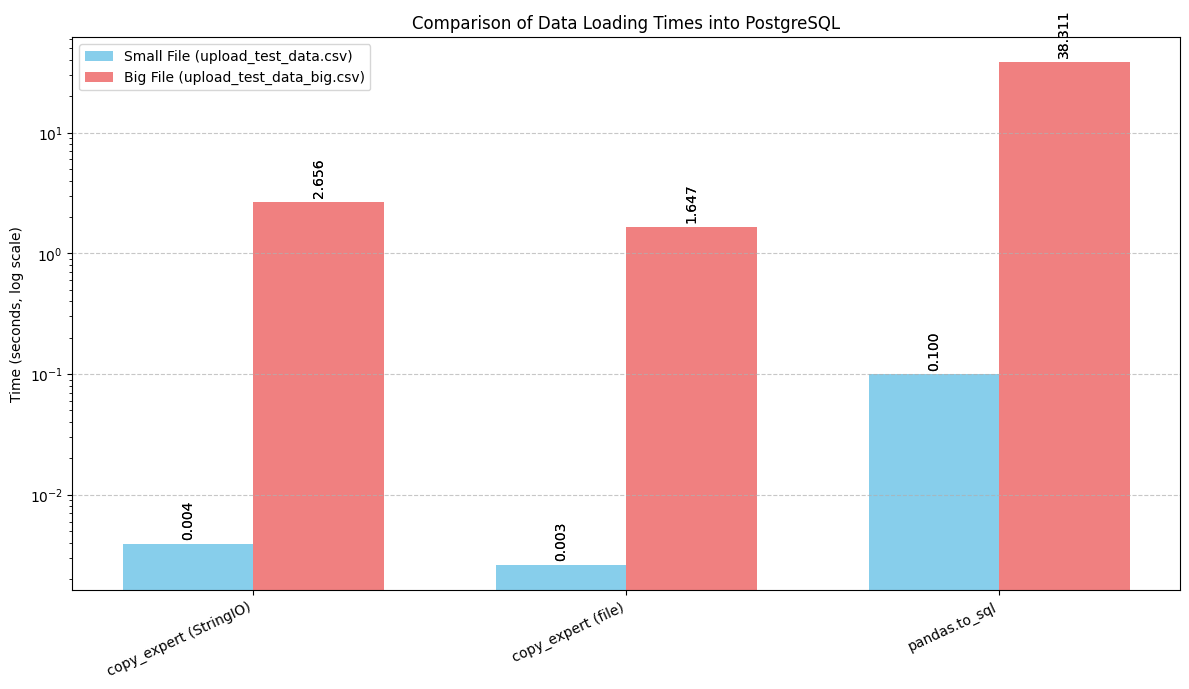

In [26]:
# @title # 7. Results Visualization
# @markdown Визуализация результатов сравнения времени загрузки.

if not timing_results['small_file'] and not timing_results['big_file']:
    print("No timing results available to plot.")
else:
    # Prepare data for plotting
    methods = list(set(timing_results['small_file'].keys()) | set(timing_results['big_file'].keys()))
    methods.sort() # Ensure consistent order

    small_times = [timing_results['small_file'].get(method, 0) for method in methods] # Use .get with default 0 if method failed
    big_times = [timing_results['big_file'].get(method, 0) for method in methods]

    x = np.arange(len(methods))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 7)) # Increase figure size for better readability

    rects1 = ax.bar(x - width/2, small_times, width, label=f'Small File ({os.path.basename(small_csv_path)})', color='skyblue')
    rects2 = ax.bar(x + width/2, big_times, width, label=f'Big File ({os.path.basename(big_csv_path)})', color='lightcoral')

    # Add some text for labels, title and axes ticks
    ax.set_ylabel('Time (seconds)')
    ax.set_title('Comparison of Data Loading Times into PostgreSQL')
    ax.set_xticks(x)
    # Rotate labels for better fit if names are long
    ax.set_xticklabels(methods, rotation=25, ha="right")
    ax.legend()

    # Add labels on top of bars
    ax.bar_label(rects1, padding=3, fmt='%.3f', rotation=90)
    ax.bar_label(rects2, padding=3, fmt='%.3f', rotation=90)

    # Use a logarithmic scale for the y-axis if the differences are very large
    # This helps visualize smaller values when large values dominate.
    # Check if the max time is significantly larger than the min non-zero time
    all_times = [t for t in small_times + big_times if t > 0]
    if all_times and (max(all_times) / min(all_times) > 50): # Threshold for using log scale
        ax.set_yscale('log')
        ax.set_ylabel('Time (seconds, log scale)')
        # Adjust label formatting for log scale if needed, though default might be fine
        ax.bar_label(rects1, padding=3, fmt='%.3f', rotation=90)
        ax.bar_label(rects2, padding=3, fmt='%.3f', rotation=90)
        print("\nNote: Using logarithmic scale for Y-axis due to large time differences.")


    fig.tight_layout() # Adjust layout to prevent labels overlapping
    plt.grid(axis='y', linestyle='--', alpha=0.7) # Add horizontal grid lines
    plt.show()

In [27]:
# @title # 8. Analysis and Conclusion
# @markdown Анализ результатов и выводы.

# @markdown ---
# @markdown ## Анализ результатов:

# @markdown 1.  **Малый файл (`upload_test_data.csv`):**
# @markdown     *   На малых объемах данных (1000 строк) разница во времени выполнения между методами может быть не столь значительной, хотя `COPY` (`copy_expert`) часто показывает лучшие результаты из-за минимальных накладных расходов.
# @markdown     *   `pandas.to_sql` (с `method='multi'`) худшая производительность, и обычно уступают `COPY`. Метод `copy_expert` с `StringIO` добавляет небольшие накладные расходы на конвертацию DataFrame -> CSV в памяти по сравнению с прямым `COPY` из файла.

# @markdown 2.  **Большой файл (`upload_test_data_big.csv`):**
# @markdown     *   На больших объемах данных (~900 тыс. строк) разница становится **критически важной**.
# @markdown     *   **`copy_expert (file)`** почти всегда является **бесспорным лидером**. Команда `COPY` в PostgreSQL чрезвычайно оптимизирована для массовой загрузки непосредственно из файла (или потока STDIN). Она минимизирует транзакционные издержки и накладные расходы на уровне SQL-парсера.
# @markdown     *   **`copy_expert (StringIO)`** также очень быстр, но немного уступает файловой версии из-за необходимости сначала создать CSV-строку в памяти. Если данные уже находятся в DataFrame в памяти, это может быть хорошим вариантом, но если исходник - файл, прямой `COPY` из файла эффективнее. *Примечание: Если большой файл не помещается в память Colab для создания DataFrame, этот метод не сработает или его результаты будут неточными.*
# @markdown     *   **`pandas.to_sql`** (даже с `chunksize` и `method='multi'`) значительно медленнее, чем `COPY`. Он имеет больше накладных расходов на уровне Python/SQLAlchemy и формирование SQL-запросов, хотя использование `chunksize` предотвращает проблемы с памятью.
# @markdown     *

# @markdown ---
# @markdown ## Вывод:

# @markdown Для **максимальной производительности** при загрузке больших объемов данных из файлов в PostgreSQL **однозначно рекомендуется использовать команду `COPY`**, доступную через `psycopg2.copy_expert()` при работе с файлами напрямую.

# @markdown Если данные уже находятся в памяти (например, в Pandas DataFrame) и их нужно загрузить, `psycopg2.copy_expert()` с `io.StringIO` является вторым по скорости вариантом, значительно опережая `pandas.to_sql` и `Batch Insert`.

# @markdown Методы `pandas.to_sql` могут быть удобны для небольших объемов данных или когда требуется большая гибкость в обработке данных перед вставкой в рамках Python-кода, но он существенно уступает `COPY` в производительности при работе с большими CSV-файлами. Важно также учитывать ограничения по памяти при использовании метода, требующего загрузки всего файла в DataFrame.

# Варианты заданий

| Вариант | Задание 1: Настройка таблиц | Задание 2: Загрузка малых данных (`sales_small`) | Задание 3: Загрузка больших данных (`sales_big`) | Задание 4: SQL Анализ | Задание 5: Python/Colab Анализ и Визуализация |
| :------ | :-------------------------- | :----------------------------------------------- | :------------------------------------------------ | :-------------------- | :---------------------------------------------- |
| **1**   | Создать таблицы `sales_small`, `sales_big`. | Метод: `pandas.to_sql()`                       | Метод: `copy_expert (file)`                       | SQL: Подсчитать среднюю стоимость (`cost`) в `sales_small`. | Python: Построить гистограмму распределения `quantity` из `sales_small`. |
| **2**   | Создать таблицы `sales_small`, `sales_big`. | Метод: `copy_expert (StringIO)`                | Метод: `copy_expert (file)`                       | SQL: Найти максимальную `total_revenue` в `sales_big`. | Python: Построить диаграмму рассеяния `cost` vs `quantity` из `sales_small`. |
| **3**   | Создать таблицы `sales_small`, `sales_big`. | Метод: `copy_expert (file)`                    | Метод: `copy_expert (file)`                       | SQL: Подсчитать записи в `sales_big`, где `cost` < 1.00. | Python: Рассчитать основные статистики (`describe()`) для `total_revenue` из `sales_big` (LIMIT 50000). |
| **4**   | Создать таблицы `sales_small`, `sales_big`. | Метод: `pandas.to_sql()`                       | Метод: `copy_expert (file)`                       | SQL: Вычислить суммарное `quantity` в `sales_small`, где `cost` > 5.00. | Python: Построить столбчатую диаграмму топ-5 `total_revenue` из `sales_small`. |
| **5**   | Создать таблицы `sales_small`, `sales_big`. | Метод: `copy_expert (file)`                    | Метод: `copy_expert (file)`                       | SQL: Найти минимальную `cost` в `sales_big`. | Python: Построить ящик с усами (boxplot) для `cost` из `sales_big` (LIMIT 50000). |
| **6**   | Создать таблицы `sales_small`, `sales_big`. | Метод: `copy_expert (StringIO)`                | Метод: `copy_expert (file)`                       | SQL: Выбрать записи из `sales_small`, где `quantity` BETWEEN 45 AND 50. | Python: Загрузить `small_csv_path` в DataFrame, рассчитать корреляцию `quantity` и `total_revenue`. |
| **7**   | Создать таблицы `sales_small`, `sales_big`. | Метод: `pandas.to_sql()`                       | Метод: `copy_expert (file)`                       | SQL: Выбрать `id`, `total_revenue` для 10 записей с макс. выручкой из `sales_big`. | Python: Извлечь результаты SQL (задание 4) в DataFrame и вывести его. |
| **8**   | Создать таблицы `sales_small`, `sales_big`. | Метод: `copy_expert (file)`                    | Метод: `copy_expert (file)`                       | SQL: Подсчитать записи в `sales_small`, где `total_revenue` > 200. | Python: Построить гистограмму `quantity` из `sales_big` (LIMIT 50000). |
| **9**   | Создать таблицы `sales_small`, `sales_big`. | Метод: `copy_expert (StringIO)`                | Метод: `copy_expert (file)`                       | SQL: Вычислить средний `cost` в `sales_big`, где `quantity` = 50. | Python: Загрузить `big_csv_path` (если возможно), рассчитать медианный `cost`. Сравнить со средним из SQL. |
| **10**  | Создать таблицы `sales_small`, `sales_big`. | Метод: `pandas.to_sql()`                       | Метод: `copy_expert (file)`                       | SQL: Найти `id` из `sales_small`, где `total_revenue` < 0.1. | Python: Извлечь 100 случайных записей из `sales_big`, построить scatter plot `quantity` vs `cost`. |
| **11**  | Создать таблицы `sales_small`, `sales_big`. | Метод: `copy_expert (file)`                    | Метод: `copy_expert (file)`                       | SQL: Рассчитать общую сумму `total_revenue` в `sales_big`. | Python: В DataFrame `sales_small` добавить колонку `revenue_check = quantity * cost`, сравнить с `total_revenue`. |
| **12**  | Создать таблицы `sales_small`, `sales_big`. | Метод: `copy_expert (StringIO)`                | Метод: `copy_expert (file)`                       | SQL: Выбрать первые 15 записей из `sales_big`, отсортированных по `cost` (ASC). | Python: Построить ящик с усами (boxplot) для `total_revenue` из `sales_small`. |
| **13**  | Создать таблицы `sales_small`, `sales_big`. | Метод: `pandas.to_sql()`                       | Метод: `copy_expert (file)`                       | SQL: Подсчитать количество уникальных `quantity` в `sales_small`. | Python: Извлечь данные из `sales_big` (LIMIT 50000), рассчитать 25-й и 75-й перцентили `cost`. |
| **14**  | Создать таблицы `sales_small`, `sales_big`. | Метод: `copy_expert (file)`                    | Метод: `copy_expert (file)`                       | SQL: Выбрать `id`, `cost` для 5 записей с самой низкой `cost` (>0) в `sales_big`. | Python: Построить гистограмму `cost` из `sales_small`. |
| **15**  | Создать таблицы `sales_small`, `sales_big`. | Метод: `copy_expert (StringIO)`                | Метод: `copy_expert (file)`                       | SQL: Вычислить суммарную `total_revenue` в `sales_small`, где `quantity` < 10. | Python: Рассчитать корреляцию `cost` и `total_revenue` в DataFrame `sales_small`. |
| **16**  | Создать таблицы `sales_small`, `sales_big`. | Метод: `pandas.to_sql()`                       | Метод: `copy_expert (file)`                       | SQL: Найти среднее `quantity` в `sales_big`, где `total_revenue` > 400. | Python: Построить scatter plot `quantity` vs `total_revenue` из `sales_big` (LIMIT 5000). |
| **17**  | Создать таблицы `sales_small`, `sales_big`. | Метод: `copy_expert (file)`                    | Метод: `copy_expert (file)`                       | SQL: Подсчитать записи в `sales_small`, где `cost` = 0.50. | Python: Рассчитать стандартное отклонение `quantity` из `sales_big` (LIMIT 50000). |
| **18**  | Создать таблицы `sales_small`, `sales_big`. | Метод: `copy_expert (StringIO)`                | Метод: `copy_expert (file)`                       | SQL: Выбрать `id` записей из `sales_big` с максимальным `quantity`. | Python: Построить гистограмму `total_revenue` из `sales_big` (LIMIT 50000). |
| **19**  | Создать таблицы `sales_small`, `sales_big`. | Метод: `pandas.to_sql()`                       | Метод: `copy_expert (file)`                       | SQL: Рассчитать суммарное `quantity` в `sales_small`, где `cost` < AVG(`cost`). (С подзапросом). | Python: Рассчитать матрицу корреляций (`cost`, `quantity`, `total_revenue`) для `sales_small`. |
| **20**  | Создать таблицы `sales_small`, `sales_big`. | Метод: `copy_expert (file)`                    | Метод: `copy_expert (file)`                       | SQL: Найти топ-5 самых частых `quantity` и их количество в `sales_big`. | Python: Построить столбчатую диаграмму для результатов SQL (задание 4). |
| **21**  | Создать таблицы `sales_small`, `sales_big`. | Метод: `copy_expert (StringIO)`                | Метод: `copy_expert (file)`                       | SQL: Вычислить % записей в `sales_small`, где `total_revenue` > 100. | Python: Рассчитать медианное значение `cost` из DataFrame `sales_small`. |
| **22**  | Создать таблицы `sales_small`, `sales_big`. | Метод: `pandas.to_sql()`                       | Метод: `copy_expert (file)`                       | SQL: Найти `id` записей в `sales_big`, где `cost` равен минимальному `cost` (>0) в таблице. | Python: Построить ящик с усами (boxplot) для `quantity` из `sales_small`. |
| **23**  | Создать таблицы `sales_small`, `sales_big`. | Метод: `copy_expert (file)`                    | Метод: `copy_expert (file)`                       | SQL: Рассчитать среднюю `total_revenue` в `sales_big`, где `quantity` BETWEEN 10 AND 20. | Python: Рассчитать стандартное отклонение `total_revenue` из `sales_big` (LIMIT 50000). |
| **24**  | Создать таблицы `sales_small`, `sales_big`. | Метод: `copy_expert (StringIO)`                | Метод: `copy_expert (file)`                       | SQL: Подсчитать записи в `sales_small`, где `cost` > 9.50. | Python: Построить scatter plot `cost` vs `total_revenue` из `sales_small`. |
| **25**  | Создать таблицы `sales_small`, `sales_big`. | Метод: `pandas.to_sql()`                       | Метод: `copy_expert (file)`                       | SQL: Выбрать топ-10 записей из `sales_big` по убыванию `quantity`. | Python: Рассчитать `.describe()` для `quantity` в DataFrame `sales_small`. |
| **26**  | Создать таблицы `sales_small`, `sales_big`. | Метод: `copy_expert (file)`                    | Метод: `copy_expert (file)`                       | SQL: Найти максимальный `cost` в `sales_small`, где `quantity` = 1. | Python: Построить гистограмму `cost` из `sales_big` (LIMIT 50000) с 20 бинами. |
| **27**  | Создать таблицы `sales_small`, `sales_big`. | Метод: `copy_expert (StringIO)`                | Метод: `copy_expert (file)`                       | SQL: Рассчитать суммарную `total_revenue` в `sales_big`, где `cost` BETWEEN 2.00 AND 3.00. | Python: Найти строки в DataFrame `sales_small`, где `abs(quantity * cost - total_revenue) > 0.01`. |
| **28**  | Создать таблицы `sales_small`, `sales_big`. | Метод: `pandas.to_sql()`                       | Метод: `copy_expert (file)`                       | SQL: Подсчитать записи в `sales_big`, где `quantity` > AVG(`quantity`). (С подзапросом). | Python: Построить гистограмму `total_revenue` из `sales_small`. |
| **29**  | Создать таблицы `sales_small`, `sales_big`. | Метод: `copy_expert (file)`                    | Метод: `copy_expert (file)`                       | SQL: Найти 5 самых редких значений `cost` в `sales_small`. | Python: Рассчитать медианное значение `quantity` из `sales_big` (LIMIT 50000). |
| **30**  | Создать таблицы `sales_small`, `sales_big`. | Метод: `copy_expert (StringIO)`                | Метод: `copy_expert (file)`                       | SQL: Выбрать `id`, `total_revenue` из `sales_small`, ORDER BY `total_revenue` ASC, OFFSET 10 LIMIT 20. | Python: Построить scatter plot `quantity` vs `cost` из `sales_big` (LIMIT 5000), раскрасив точки (cost > 5). |

## **Вариант 15**

In [28]:
# @title Вспомогательные Функции (Часть Базового Кода)
# Убедитесь, что эта ячейка выполняется ПЕРЕД запуском кода варианта

# ... (здесь должны быть определения connect_db, close_db, execute_sql, load_df_from_sql и т.д.)

def execute_sql(sql_query, fetch=False):
    """Выполняет SQL-запрос и опционально возвращает результаты."""
    if not connection or not cursor:
        print("Нет подключения к БД.")
        return None
    try:
        # print(f"Выполнение SQL: {sql_query[:100]}...") # Отладка: показать начало запроса
        cursor.execute(sql_query)
        if fetch:
            results = cursor.fetchall()
            # print("Результаты получены.") # Отладка
            return results
        else:
            # Для запросов не SELECT (CREATE, DROP, INSERT, UPDATE, DELETE)
            # connection.commit() # Не требуется при autocommit=True
            # print("Запрос успешно выполнен (без fetch).") # Отладка
            return True # Возвращаем True для индикации успеха выполнения не-SELECT запроса
    except (Exception, Error) as error:
        print(f"Ошибка выполнения SQL: {error}")
        # connection.rollback() # Не требуется при autocommit=True
        return None # Возвращаем None для индикации ошибки

# --- Функция создания таблицы ---
def create_table(tbl_name):
    """Создает стандартную таблицу для данных продаж, удаляя ее, если она существует."""
    print(f"\nПопытка создать таблицу: {tbl_name}")
    # Шаг 1: Удалить таблицу, если она уже существует
    # Это важно для повторяемости: гарантирует, что мы начинаем с чистого листа
    # и не получим ошибку "table already exists".
    drop_success = execute_sql(f"DROP TABLE IF EXISTS {tbl_name};")
    if drop_success is None: # Проверяем, не было ли ошибки при DROP
        print(f"Не удалось выполнить DROP TABLE для {tbl_name}. Создание таблицы отменено.")
        return # Прерываем создание, если DROP не удался

    # Шаг 2: Определить SQL-запрос для создания таблицы
    # Структура таблицы (колонки и типы данных) соответствует анализу
    # из исходной практической работы. Имя таблицы берется из аргумента tbl_name.
    create_query = f"""
    CREATE TABLE {tbl_name} (
        id INTEGER PRIMARY KEY,         -- Уникальный идентификатор, первичный ключ
        quantity INTEGER,               -- Количество
        cost NUMERIC(10, 2),            -- Стоимость (NUMERIC для точности)
        total_revenue NUMERIC(12, 2)    -- Общая выручка (NUMERIC для точности)
    );
    """
    print(f"Запрос на создание таблицы {tbl_name}:\n{create_query}")

    # Шаг 3: Выполнить SQL-запрос на создание таблицы
    create_success = execute_sql(create_query)
    if create_success:
        print(f"Таблица '{tbl_name}' успешно создана.")
    else:
        print(f"Не удалось создать таблицу '{tbl_name}'.")

# ... (здесь определения load_via_pandas, load_via_copy_file, load_via_copy_stringio и т.д.)# @title Вспомогательные Функции (Часть Базового Кода - УБЕДИТЕСЬ, ЧТО ЭТА ЯЧЕЙКА ВЫПОЛНЕНА!)

# ... (импорты, константы, connect_db, close_db, execute_sql, load_df_from_sql, create_table) ...

# --- Функции Загрузки Данных ---

def load_via_copy_stringio(df, tbl_name):
    """Загружает данные из DataFrame через StringIO, используя copy_expert."""
    # Проверка подключения и наличия данных
    if not connection or not cursor or df is None:
        print("Нет подключения к БД или DataFrame пуст.")
        return False # Возвращаем False при неудаче
    print(f"Загрузка данных в '{tbl_name}' с использованием copy_expert (StringIO)...")
    start_time = time.time()
    buffer = io.StringIO() # Создаем буфер в памяти
    # Записываем DataFrame в буфер как CSV, включая заголовок
    try:
        df.to_csv(buffer, index=False, header=True, sep=',')
    except Exception as e:
         print(f"Ошибка конвертации DataFrame в CSV: {e}")
         buffer.close() # Закрываем буфер при ошибке
         return False # Возвращаем False при неудаче
    buffer.seek(0) # Перематываем буфер в начало для чтения
    # Формируем SQL команду COPY
    sql_copy = f"COPY {tbl_name} FROM STDIN WITH (FORMAT CSV, HEADER TRUE, DELIMITER ',')"
    try:
        # Выполняем COPY, передавая буфер как файл
        cursor.copy_expert(sql=sql_copy, file=buffer)
        # connection.commit() # Не требуется при autocommit=True
        duration = time.time() - start_time
        print(f"Успешно: Загрузка (StringIO) в '{tbl_name}' завершена за {duration:.2f} сек.")
        return True # Возвращаем True при успехе
    except (Exception, Error) as error:
        print(f"ОШИБКА при выполнении copy_expert (StringIO) для '{tbl_name}': {error}")
        # connection.rollback() # Не требуется при autocommit=True
        return False # Возвращаем False при неудаче
    finally:
        buffer.close() # Гарантируем закрытие буфера в любом случае

def load_via_copy_file(file_path, tbl_name):
    """Загружает данные напрямую из CSV файла, используя copy_expert."""
    # Проверка подключения
    if not connection or not cursor:
       print("Нет подключения к БД.")
       return False # Возвращаем False при неудаче
    # Проверка существования файла
    if not os.path.exists(file_path):
        print(f"ОШИБКА: Файл '{file_path}' не найден.")
        return False # Возвращаем False при неудаче
    print(f"Загрузка данных в '{tbl_name}' с использованием copy_expert (file: {os.path.basename(file_path)})...")
    start_time = time.time()
    # Формируем SQL команду COPY
    sql_copy = f"COPY {tbl_name} FROM STDIN WITH (FORMAT CSV, HEADER TRUE, DELIMITER ',')"
    try:
        # Открываем файл для чтения и передаем его дескриптор в copy_expert
        with open(file_path, 'r', encoding='utf-8') as f:
            cursor.copy_expert(sql=sql_copy, file=f)
        # connection.commit() # Не требуется при autocommit=True
        duration = time.time() - start_time
        print(f"Успешно: Загрузка (file) в '{tbl_name}' завершена за {duration:.2f} сек.")
        return True # Возвращаем True при успехе
    except (Exception, Error) as error:
        print(f"ОШИБКА при выполнении copy_expert (file) для '{tbl_name}': {error}")
        # connection.rollback() # Не требуется при autocommit=True
        return False # Возвращаем False при неудаче

# ... (другие вспомогательные функции, если есть) ...

print("Вспомогательные функции определены.")# @title Вспомогательные Функции (Часть Базового Кода - УБЕДИТЕСЬ, ЧТО ЭТА ЯЧЕЙКА ВЫПОЛНЕНА!)

# ... (импорты, константы, connect_db, close_db, execute_sql, create_table, ...) ...

# --- Функция загрузки данных из SQL в DataFrame ---
def load_df_from_sql(sql_query):
    """Выполняет SQL-запрос и загружает результаты в Pandas DataFrame."""
    # Проверяем наличие активного подключения
    if not connection: # Для read_sql_query достаточно объекта connection
        print("Нет подключения к БД для загрузки DataFrame.")
        return None # Возвращаем None при ошибке
    print(f"Загрузка данных из SQL в DataFrame: {sql_query[:100]}...") # Показываем начало запроса
    try:
        # Используем pandas.read_sql_query для выполнения запроса и создания DataFrame
        # Эта функция сама управляет курсором и соединением для чтения
        df = pd.read_sql_query(sql_query, connection)
        print(f"Успешно: Загружено {len(df)} строк в DataFrame.")
        return df # Возвращаем созданный DataFrame
    except (Exception, Error) as error:
        # Обрабатываем ошибки при выполнении запроса или создании DataFrame
        print(f"ОШИБКА при загрузке DataFrame из SQL: {error}")
        return None # Возвращаем None при ошибке

# ... (определения load_via_copy_stringio, load_via_copy_file и другие функции) ...

print("Вспомогательные функции определены.")

Вспомогательные функции определены.
Вспомогательные функции определены.


Успешное подключение к PostgreSQL
--- Запуск Варианта 15 (Упрощенная загрузка) ---

--- Задача 1: Создание таблиц ---
Таблица sales_small успешно создана или уже существует
Таблица sales_big успешно создана или уже существует

--- Задача 2: Загрузка данных из 'C:\Users\arssi\Downloads\upload_test_data.csv' в 'sales_small' (метод StringIO) ---
Чтение C:\Users\arssi\Downloads\upload_test_data.csv в DataFrame...
Прочитано 1000 строк.
Загрузка данных в 'sales_small' с использованием copy_expert (StringIO)...
Успешно: Загрузка (StringIO) в 'sales_small' завершена за 0.00 сек.

--- Задача 3: Загрузка данных из 'C:\Users\arssi\Downloads\upload_test_data_big.csv' в 'sales_big' ---
Данные из C:\Users\arssi\Downloads\upload_test_data_big.csv успешно загружены в sales_big

--- Задача 4: SQL Анализ таблицы sales_small ---
Выполнение SQL запроса:

    SELECT SUM(total_revenue) AS total_revenue_sum
    FROM sales_small
    WHERE quantity < 10;
    

Результаты запроса (суммарная выручка для quantity

C:\Users\arssi\AppData\Local\Temp\ipykernel_18000\256441082.py:86: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, connection)


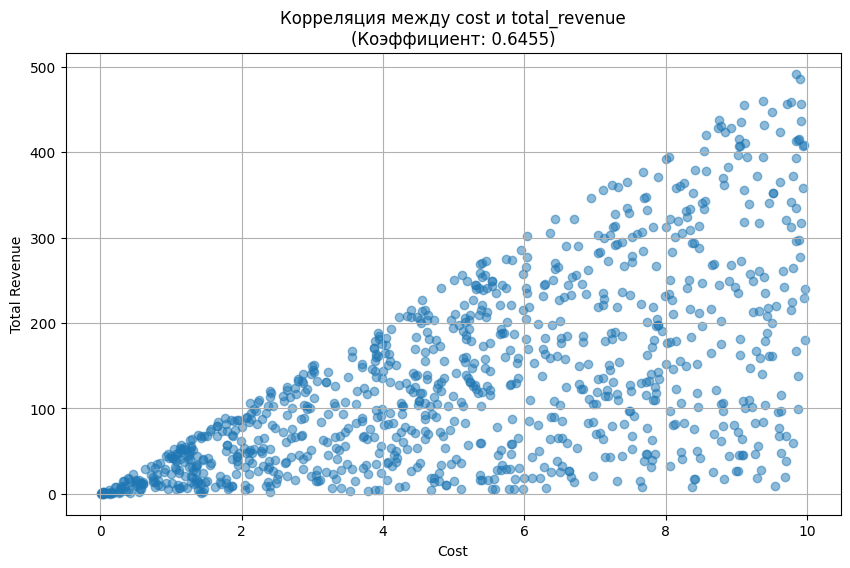


Интерпретация: умеренная положительная корреляция между cost и total_revenue


In [30]:
# -*- coding: utf-8 -*-
"""
Мини-проект: Решение для Варианта 15
"""

import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import os
from io import StringIO

# --- Константы для подключения к PostgreSQL ---
DB_USER = "postgres"
DB_PASSWORD = "1"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "work"       

# --- Константы для этого варианта ---
small_table_name = 'sales_small'
big_table_name = 'sales_big'
small_csv_path = r'C:\Users\arssi\Downloads\upload_test_data.csv'  
big_csv_path = r'C:\Users\arssi\Downloads\upload_test_data_big.csv'

# Функция для подключения к БД
def connect_db():
    try:
        connection = psycopg2.connect(
            dbname=DB_NAME,
            user=DB_USER,
            password=DB_PASSWORD,
            host=DB_HOST,
            port=DB_PORT
        )
        cursor = connection.cursor()
        print("Успешное подключение к PostgreSQL")
        return connection, cursor
    except Exception as e:
        print(f"Ошибка подключения к PostgreSQL: {e}")
        return None, None

# Функция для создания таблицы
def create_table(table_name):
    try:
        cursor.execute(f"""
        CREATE TABLE {table_name} (
            id INTEGER PRIMARY KEY,
            quantity INTEGER,
            cost NUMERIC(10, 2),
            total_revenue NUMERIC(12, 2)
        );
        """)
        connection.commit()
        print(f"Таблица {table_name} успешно создана или уже существует")
    except Exception as e:
        print(f"Ошибка при создании таблицы {table_name}: {e}")

# Функция для загрузки данных из файла
def load_via_copy_file(file_path, table_name):
    try:
        with open(file_path, 'r') as f:
            cursor.copy_expert(f"""
            COPY {table_name}(id, quantity, cost, total_revenue) 
            FROM STDIN WITH CSV HEADER DELIMITER ','
            """, f)
        connection.commit()
        print(f"Данные из {file_path} успешно загружены в {table_name}")
    except Exception as e:
        print(f"Ошибка при загрузке данных в {table_name}: {e}")

# Функция для выполнения SQL запросов
def execute_sql(query, fetch=False):
    try:
        cursor.execute(query)
        connection.commit()
        if fetch:
            return cursor.fetchall()
        return True
    except Exception as e:
        print(f"Ошибка выполнения SQL запроса: {e}")
        return None

# Функция для загрузки данных в DataFrame
def load_df_from_sql(query):
    try:
        return pd.read_sql(query, connection)
    except Exception as e:
        print(f"Ошибка загрузки данных в DataFrame: {e}")
        return None


connection, cursor = connect_db()

if not connection or not cursor:
    print("Подключение к базе данных неактивно. Пожалуйста, проверьте параметры подключения.")
else:
    print("--- Запуск Варианта 15 (Упрощенная загрузка) ---")


    # --- Задача 1: Настройка таблиц ---
    print("\n--- Задача 1: Создание таблиц ---")
    create_table(small_table_name)
    create_table(big_table_name)
    # Функция create_table должна вывести сообщения об успехе/ошибке

    # --- Задача 2: Загрузка малых данных (copy_expert StringIO) ---
    print(f"\n--- Задача 2: Загрузка данных из '{small_csv_path}' в '{small_table_name}' (метод StringIO) ---")
    if os.path.exists(small_csv_path):
        try:
            # Шаг 1: Читаем CSV в DataFrame (необходимо для StringIO)
            print(f"Чтение {small_csv_path} в DataFrame...")
            df_small_for_load = pd.read_csv(small_csv_path)
            print(f"Прочитано {len(df_small_for_load)} строк.")

            # Шаг 2: Вызываем функцию загрузки через StringIO
            load_via_copy_stringio(df_small_for_load, small_table_name)
            # Функция load_via_copy_stringio выведет сообщение об успехе/ошибке загрузки

        except pd.errors.EmptyDataError:
             print(f"ОШИБКА: Файл '{small_csv_path}' пуст или имеет неверный формат.")
        except MemoryError:
             print(f"ОШИБКА: Недостаточно памяти для загрузки '{small_csv_path}' в DataFrame.")
        except Exception as e:
            # Ловим другие возможные ошибки при чтении файла
            print(f"ОШИБКА при чтении файла '{small_csv_path}': {e}")
    else:
        # Сообщение, если файл не найден
        print(f"ОШИБКА: Файл '{small_csv_path}' не найден. Загрузка не выполнена.")


    # --- Задача 3: Загрузка больших данных ---
    print(f"\n--- Задача 3: Загрузка данных из '{big_csv_path}' в '{big_table_name}' ---")
    if os.path.exists(big_csv_path):
        load_via_copy_file(big_csv_path, big_table_name)
    else:
        print(f"ОШИБКА: Файл '{big_csv_path}' не найден.")

    # --- Задача 4: SQL Анализ ---
        # --- Задача 4: SQL Анализ ---
    print("\n--- Задача 4: SQL Анализ таблицы sales_small ---")
    sql_query_task4 = f"""
    SELECT SUM(total_revenue) AS total_revenue_sum
    FROM {small_table_name}
    WHERE quantity < 10;
    """
    print("Выполнение SQL запроса:")
    print(sql_query_task4)
    results_task4 = execute_sql(sql_query_task4, fetch=True)

    if results_task4 is not None:
        print("\nРезультаты запроса (суммарная выручка для quantity < 10):")
        if results_task4:
            for row in results_task4:
                print(row)
        else:
            print("Запрос успешно выполнен, но не вернул строк.")
    else:
        print("Ошибка выполнения SQL запроса.")

    # --- Задача 5: Python Визуализация ---
    # --- Расчет корреляции между cost и total_revenue ---
print("\n--- Расчет корреляции между cost и total_revenue в sales_small ---")

sql_query_corr = f"SELECT cost, total_revenue FROM {small_table_name};"
df_corr = load_df_from_sql(sql_query_corr)

if df_corr is not None and not df_corr.empty:
    # Рассчитываем корреляцию
    correlation = df_corr['cost'].corr(df_corr['total_revenue'])
    
    print(f"\nКоэффициент корреляции между cost и total_revenue: {correlation:.4f}")
    
    # Визуализация 
    plt.figure(figsize=(10, 6))
    plt.scatter(df_corr['cost'], df_corr['total_revenue'], alpha=0.5)
    plt.title(f'Корреляция между cost и total_revenue\n(Коэффициент: {correlation:.4f})')
    plt.xlabel('Cost')
    plt.ylabel('Total Revenue')
    plt.grid(True)
    plt.show()
    
    # Интерпретация результата
    if abs(correlation) > 0.7:
        strength = "сильная"
    elif abs(correlation) > 0.3:
        strength = "умеренная"
    else:
        strength = "слабая"
    
    direction = "положительная" if correlation > 0 else "отрицательная"
    
    print(f"\nИнтерпретация: {strength} {direction} корреляция между cost и total_revenue")
else:
    print("ОШИБКА: Не удалось загрузить данные для расчета корреляции или таблица пуста")

    # Закрытие соединения
    if cursor:
        cursor.close()
    if connection:
        connection.close()
        print("\nСоединение с базой данных закрыто.")